In [1]:

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from models.merge import CNN, BiLSTM, ELMo
from keras.models import Model
from data.Dataset import Dataset
from data.TrainSet import TrainSet
from keras.utils.vis_utils import plot_model
from keras import layers, optimizers, metrics
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
from utils.utils import plot_words_cloud, plot_words_count, plot_compare_bars, plot_eval
tqdm.pandas(desc="progress-bar")
nltk.download('stopwords')
elmo = ELMo()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chrysalis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chrysalis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2021-11-09 23:29:40,939 : INFO : Loading model from ./212/...
2021-11-09 23:29:41,415 : INFO : We will cache the vocabulary of 100 tokens.
d:\study\semester 9\gan_env\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:901: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
d:\study\semester 9\gan_env\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. P

Read books

In [2]:
name_A = "Nekrasov"
name_B = "Pushkin"

dataset = Dataset([name_A, name_B])
dataset.data

,label,author,text
0,0,Nekrasov,Николай Некрасов\nВ ДОРОГЕ\n«Скучно! скучно!....
1,1,Pushkin,Александр Пушкин\n19 ОКТЯБРЯ\nРоняет лес багр...


Clean text from punctuation

In [3]:
dataset.preprocess()
dataset.data


,label,author,text
0,0,Nekrasov,николай некрасов дорога скучно скучно ямщик уд...
1,1,Pushkin,александр пушкин октябрь ронять лес багряный с...


VISUALIZING THE DATA

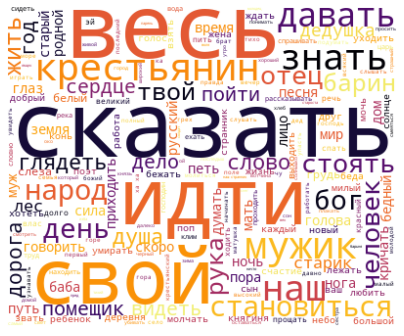

<Figure size 432x288 with 0 Axes>

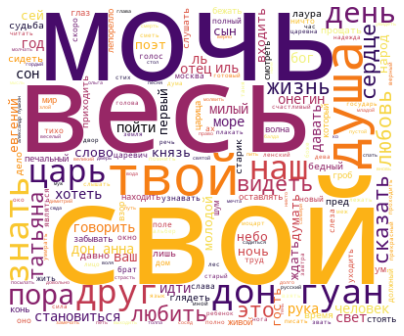

<Figure size 432x288 with 0 Axes>

In [4]:
plot_words_cloud(dataset.data)

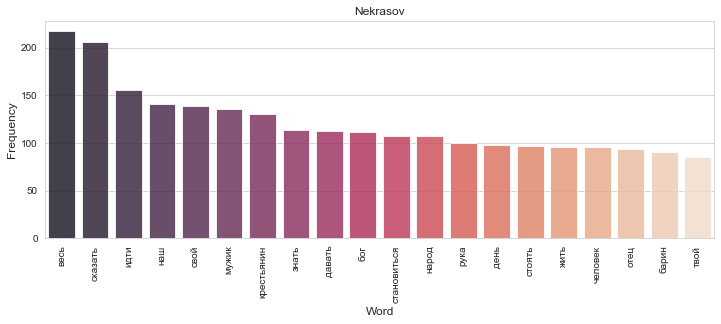

<Figure size 432x288 with 0 Axes>

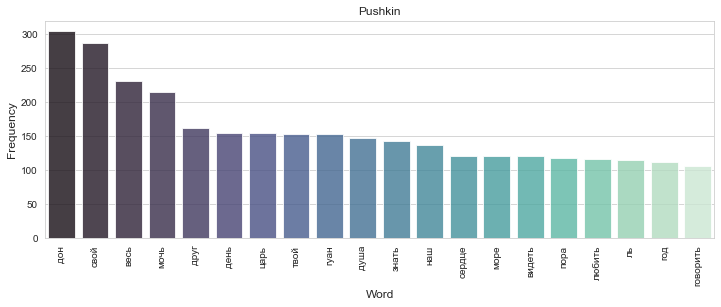

<Figure size 432x288 with 0 Axes>

In [5]:
plot_words_count(dataset.data)

Count and visualize as barplots

d:\study\semester 9\gan_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


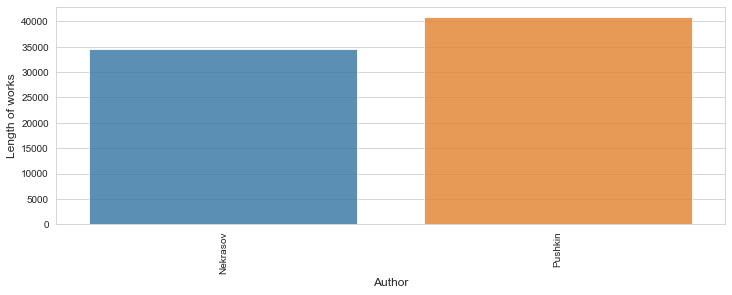

<Figure size 432x288 with 0 Axes>

In [6]:
plot_compare_bars(dataset.data)

In [7]:
dataset.chunking()
dataset.prep_data

,label,author,text
0,0,Nekrasov,"[николай, некрасов, дорога, скучно, скучно, ям..."
1,0,Nekrasov,"[варган, играть, читать, весь, дворянский, ман..."
2,0,Nekrasov,"[судить, нужный, сто, дворянство, холопка, вых..."
3,0,Nekrasov,"[напросто, тесно, вместе, жить, показываться, ..."
4,0,Nekrasov,"[корова, грех, сказать, ленивый, вишь, дело, р..."
...,...,...,...
1015,1,Pushkin,"[таилася, угасать, пламень, страстный, веселие..."
1016,1,Pushkin,"[бежать, толпа, обманчивый, мечтание, сожигать..."
1017,1,Pushkin,"[ох, анна, львовна, василье, львович, сестра, ..."
1018,1,Pushkin,"[подлец, попович, красовский, пропускать, алек..."


In [8]:
data_as_list = list(dataset.prep_data['text'])
embeddings = elmo.get_elmo_vectors(data_as_list)
embeddings.shape

2021-11-09 23:31:06,899 : INFO : Warming up ELMo on 40 sentences...
2021-11-09 23:31:36,736 : INFO : Warming up finished.
2021-11-09 23:31:36,746 : INFO : Texts in the current batch: 40
2021-11-09 23:31:36,956 : INFO : Texts in the current batch: 40
2021-11-09 23:31:37,124 : INFO : Texts in the current batch: 40
2021-11-09 23:31:37,296 : INFO : Texts in the current batch: 40
2021-11-09 23:31:37,475 : INFO : Texts in the current batch: 40
2021-11-09 23:31:37,649 : INFO : Texts in the current batch: 40
2021-11-09 23:31:37,822 : INFO : Texts in the current batch: 40
2021-11-09 23:31:38,011 : INFO : Texts in the current batch: 40
2021-11-09 23:31:38,184 : INFO : Texts in the current batch: 40
2021-11-09 23:31:38,357 : INFO : Texts in the current batch: 40
2021-11-09 23:31:38,524 : INFO : Texts in the current batch: 40
2021-11-09 23:31:38,685 : INFO : Texts in the current batch: 40
2021-11-09 23:31:38,839 : INFO : Texts in the current batch: 40
2021-11-09 23:31:39,016 : INFO : Texts in the 

(1884, 40, 1024)

In [9]:
dataset.set_embeddings(embeddings)
dataset.prep_data

,label,author,text,embedding
0,0,Nekrasov,"[николай, некрасов, дорога, скучно, скучно, ям...","[[0.1261032372713089, -0.2387339174747467, -0...."
1,0,Nekrasov,"[варган, играть, читать, весь, дворянский, ман...","[[-0.3502512574195862, 0.4684178829193115, 0.3..."
2,0,Nekrasov,"[судить, нужный, сто, дворянство, холопка, вых...","[[-0.29161810874938965, -0.5574569702148438, -..."
3,0,Nekrasov,"[напросто, тесно, вместе, жить, показываться, ...","[[-0.25844985246658325, 0.2402917891740799, 0...."
4,0,Nekrasov,"[корова, грех, сказать, ленивый, вишь, дело, р...","[[0.0038333795964717865, -0.5180422067642212, ..."
...,...,...,...,...
1015,1,Pushkin,"[таилася, угасать, пламень, страстный, веселие...","[[0.08734554797410965, -0.5055018663406372, -0..."
1016,1,Pushkin,"[бежать, толпа, обманчивый, мечтание, сожигать...","[[-0.057734400033950806, 0.009399332106113434,..."
1017,1,Pushkin,"[ох, анна, львовна, василье, львович, сестра, ...","[[0.20898392796516418, -0.34968101978302, -0.4..."
1018,1,Pushkin,"[подлец, попович, красовский, пропускать, алек...","[[-0.34733814001083374, -1.156172275543213, -0..."


In [10]:
train_set = TrainSet(dataset.prep_data)
train_set.shape

,Train,Test
X,"(1601, 40, 1024)","(283, 40, 1024)"
Y,"(1601,)","(283,)"


In [11]:
cnn = CNN(train_set.X_shape())
cnn.build()

Model: "CNN"
____________________________________________________________________________________________________________________________________________
Layer (type)                                  Output Shape                   Param #         Connected to                                   
input_1 (InputLayer)                          [(None, 40, 1024)]             0                                                              
____________________________________________________________________________________________________________________________________________
conv1d (Conv1D)                               (None, 38, 200)                614600          input_1[0][0]                                  
____________________________________________________________________________________________________________________________________________
conv1d_1 (Conv1D)                             (None, 37, 200)                819400          input_1[0][0]                                  


In [ ]:
cnn.fit(train_set)

Train on 1601 samples


In [ ]:
cnn.predict(train_set)

In [ ]:
bilstm = BiLSTM(train_set.X_shape())
bilstm.build()

In [ ]:
bilstm.fit(train_set)

In [ ]:
bilstm.predict(train_set)

In [ ]:
input_shape = layers.Input(shape=X_train[0].shape)

forward_lstm = layers.LSTM(40)  #(input_shape)
backward_lstm = layers.LSTM(40, go_backwards=True)  #(input_shape)

model = layers.Bidirectional(forward_lstm, backward_layer=backward_lstm)(input_shape)
model = layers.Dropout(rate=.2)(model)
model = layers.Dense(30, activation='relu')(model)
model = layers.Dropout(rate=.2)(model)
model = layers.Dense(3, activation='softmax')(model)
#model = layers.Dense(3, activation='softmax')(model)
bilstm = Model(inputs=input_shape, outputs=model, name="BiLSTM")
# output model skeleton
print(bilstm.summary())
plot_model(bilstm, "bilstm.png", show_shapes=True)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
bilstm.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['acc'])
history = bilstm.fit(X_train, Y_train, epochs=10, batch_size=50, verbose=2)

In [ ]:
# evaluate the model
_, train_acc = bilstm.evaluate(X_train, Y_train, verbose=2)
_, test_acc = bilstm.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

In [ ]:
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig('model_loss.png')

In [ ]:
predict_x = bilstm.predict(X_test)
Y_pred = np.argmax(predict_x, axis=1)

df_test = pd.DataFrame({'true': Y_test, 'pred': Y_pred})
tn, fp, fn, tp = confusion_matrix(df_test.true, df_test.pred).ravel()
c_matrix = pd.DataFrame({1: [tp, fp], 0: [fn, tn]}, index=[1, 0])
print(f"confusion matrix:\n {c_matrix}")
print(classification_report(df_test.true, df_test.pred))

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)  #  model.predict_classes(X_test, verbose=0)
print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

In [ ]:
rounded_labels = np.argmax(Y_test, axis=1)
rounded_labels

In [ ]:
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

In [ ]:
# The confusion matrix

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

# Validation

In [ ]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score, acc = model.evaluate(X_test, Y_test, verbose=1, batch_size=batch_size)

print("score: %.2f" % score)
print("acc: %.2f" % acc)

**Save Model**

In [ ]:
model.save('Mymodel.h5')

**Test with new and different data set aside from the data to build the model.**

note : sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

In [ ]:
message = ['Congratulations! you have won a $1,000 Walmart gift card']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['such massive asteroid hit will certainly create new business opportunities']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['so does anyone else not open Snapchat anymore ? or is it just me ... ugh this so sad.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = [
    '@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = [
    'The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])

In [ ]:
message = ['The local electronics industry is amid layoff concerns and last year has laid off tens of employees']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0', '1', '2']
print(pred, labels[np.argmax(pred)])